# 🩺 Predicting 30-Day Readmission in Diabetic Patients  
*(Educational demo using XGBoost + SHAP)*

## Why?
Hospital readmissions within 30 days are costly for healthcare systems and stressful for patients.  
Identifying risk factors early can help improve patient management, allocate resources efficiently,  
and potentially reduce avoidable readmissions.

## What are we doing?
- **Goal:** Predict whether a patient with diabetes will be readmitted within 30 days.  
- **Approach:** Train a machine learning model (**XGBoost**) and interpret its predictions using **SHAP**.  
- **Outputs:**  
  - Model evaluation (ROC-AUC, PR-AUC)  
  - Global feature importance (SHAP beeswarm, bar plots)  
  - Local patient-level explanations (waterfall plots)  
  - Cohort summaries (risk profiles for subgroups)

## What data are we using?
We use the open **Diabetes 130-US hospitals dataset (1999–2008)**:  
- >100,000 hospital admissions of diabetic patients across 130 U.S. hospitals  
- Demographics, lab results, hospital utilization, medications, and outcomes  
- Publicly available via UCI / Kaggle  
- Target label: **Readmission within 30 days (`<30`)**

⚠️ **Disclaimer:** This notebook is for **educational purposes only**.  
It is **not** intended for clinical decision-making.


In [41]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings, re
warnings.filterwarnings("ignore")   # keep the notebook tidy

# Reproducibility
np.random.seed(42)

# Modeling
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

# Explainability
import shap
shap.initjs()  # enables interactive SHAP visuals in the notebook

In [42]:
# loads the “Diabetes 130‑US hospitals” csv,
# turns unknowns "?" into proper NaN,
# drops ID‑like columns and rarely used fields that add noise,
# removes records with invalid gender,
# excludes “death” discharge codes (cannot be readmitted),
# creates the target label y = 1 if readmitted within 30 days ("<30").

# Load
# https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008
PATH = "data/diabetic_data.csv"
df = pd.read_csv(PATH)
df = df.replace("?", np.nan)  # canonical missing values

# Drop noisy / ID columns
# print(df["weight"].value_counts(normalize=True))
# print(df["weight"].isna().mean() * 100)

drop_cols = ["encounter_id", "patient_nbr", "weight", "payer_code", "medical_specialty"]
df = df.drop(columns=drop_cols, errors="ignore")

# Remove invalid gender rows
df = df[df["gender"] != "Unknown/Invalid"]

# Remove 'death' discharge dispositions (e.g., 11, 19, 20, 21 in this dataset)
if "discharge_disposition_id" in df.columns:
    df = df[~df["discharge_disposition_id"].isin([11,19,20,21])]

# Build label: readmitted within 30 days
df["y"] = (df["readmitted"] == "<30").astype(int)
df = df.drop(columns=["readmitted"])


In [43]:
# Helper functions & feature engineering
## Converts age ranges like "[70-80)" to midpoints (e.g., 75),
## Creates binary biomarkers for A1C and glucose (“high vs not high”),
## encodes medication variables in two intuitive ways:
### *_any → whether a drug was used at all (treatment exposure),
### *_change → whether its dose changed up/down (treatment instability).

def age_to_midpoint(age_str):
    # "[70-80)" -> 75
    m = re.match(r"\[(\d+)-(\d+)\)", str(age_str))
    if not m: 
        return np.nan
    a,b = int(m.group(1)), int(m.group(2))
    return (a+b)/2

def binarize_a1c(val):
    # mark elevated A1C (proxy for poor glycemic control)
    if pd.isna(val): return 0
    return 1 if (">7" in val or ">8" in val) else 0

def binarize_glucose(val):
    # mark elevated max glucose ( >200 / >300 )
    if pd.isna(val): return 0
    return 1 if (">200" in val or ">300" in val) else 0

def on_change(val):
    # medication change ('Up' or 'Down') → 1; steady/no/NaN → 0
    if pd.isna(val): return 0
    return 1 if val in ["Up", "Down"] else 0

def any_use(val):
    # any medication exposure (anything but 'No') → 1
    if pd.isna(val): return 0
    return 0 if val == "No" else 1


In [44]:
# Build a compact, interpretable feature set

# collects clinically intuitive numeric counts (labs, meds, inpatient episodes…),
# converts age, A1C, glucose, admission metadata, sex,
# for selected antidiabetic drugs: creates *_any and *_change,
# drops rows with missing values in these engineered features.

features = {}

# Core utilization/severity signals
for col in [
    "time_in_hospital","num_lab_procedures","num_procedures","num_medications",
    "number_outpatient","number_emergency","number_inpatient","number_diagnoses"
]:
    features[col] = pd.to_numeric(df[col], errors="coerce")

# Age midpoint from brackets
features["age_mid"] = df["age"].apply(age_to_midpoint)

# Biomarkers to simple flags
if "A1Cresult" in df.columns:
    features["A1C_high"] = df["A1Cresult"].apply(binarize_a1c)
if "max_glu_serum" in df.columns:
    features["max_glu_serum_high"] = df["max_glu_serum"].apply(binarize_glucose)

# Admission metadata (already numeric in dataset)
for col in ["admission_type_id","discharge_disposition_id","admission_source_id"]:
    if col in df.columns:
        features[col] = pd.to_numeric(df[col], errors="coerce")

# Sex
features["is_male"] = (df["gender"] == "Male").astype(int)

# Drug exposure & change
for drug in ["insulin","metformin","glimepiride","glyburide","pioglitazone","rosiglitazone"]:
    if drug in df.columns:
        features[f"{drug}_change"] = df[drug].apply(on_change)
        features[f"{drug}_any"] = df[drug].apply(any_use)

# Final matrix
X = pd.DataFrame(features)
y = df["y"].astype(int)

# Keep only rows with complete data for this compact feature set
mask = X.notna().all(axis=1)
X = X[mask]; y = y[mask]

X.shape, y.mean()  # sanity check: matrix shape and positive class rate

((100111, 27), np.float64(0.11344407707444737))

In [45]:
# Split data & train XGBoost with early stopping

# stratified split into train/valid/test (70/15/15),
# computes scale_pos_weight to counter class imbalance,
# trains XGBoost with early stopping on the validation set,
# uses PR‑AUC (aucpr) as eval metric (better for imbalanced clinical tasks).

# Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# Handle class imbalance (approx. neg/pos ratio)
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos,1)

# Model
model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="aucpr",          # optimize PR-AUC
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# Train with early stopping on validation set
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False,
    early_stopping_rounds=50
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


ROC-AUC: 0.666 | PR-AUC: 0.215


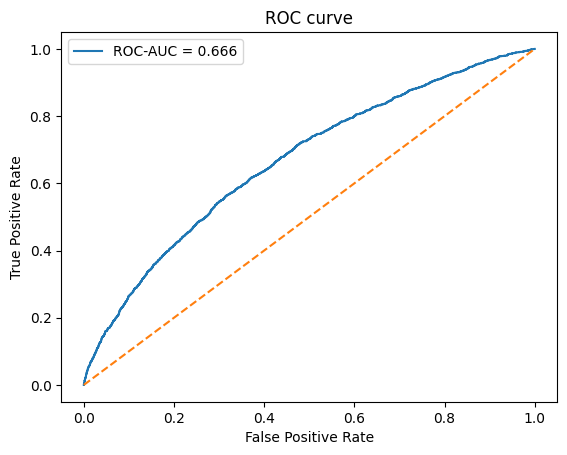

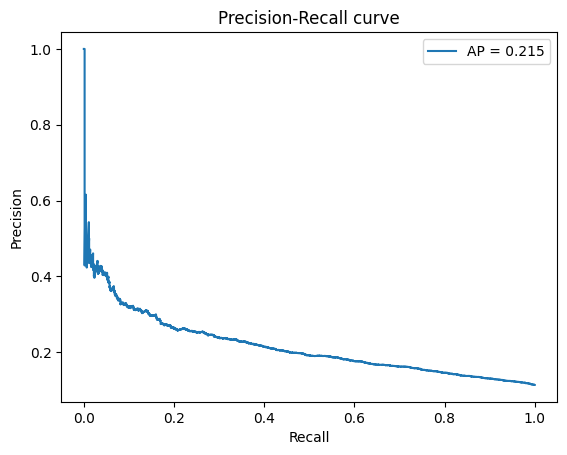

In [46]:
# Evaluate with ROC and PR curves

# computes ROC‑AUC and PR‑AUC (Average Precision),
# plots ROC and Precision‑Recall curves for quick visual quality control.

proba_test = model.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, proba_test)
ap  = average_precision_score(y_test, proba_test)

print(f"ROC-AUC: {roc:.3f} | PR-AUC: {ap:.3f}")

fpr, tpr, _ = roc_curve(y_test, proba_test)
prec, rec, _ = precision_recall_curve(y_test, proba_test)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curve"); plt.legend(); plt.show()

plt.figure()
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall curve"); plt.legend(); plt.show()


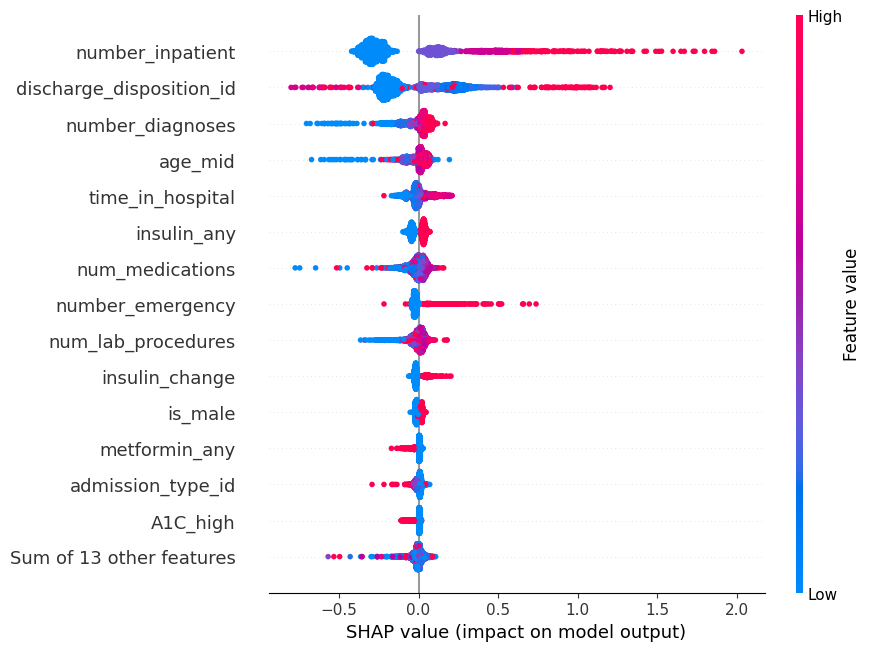

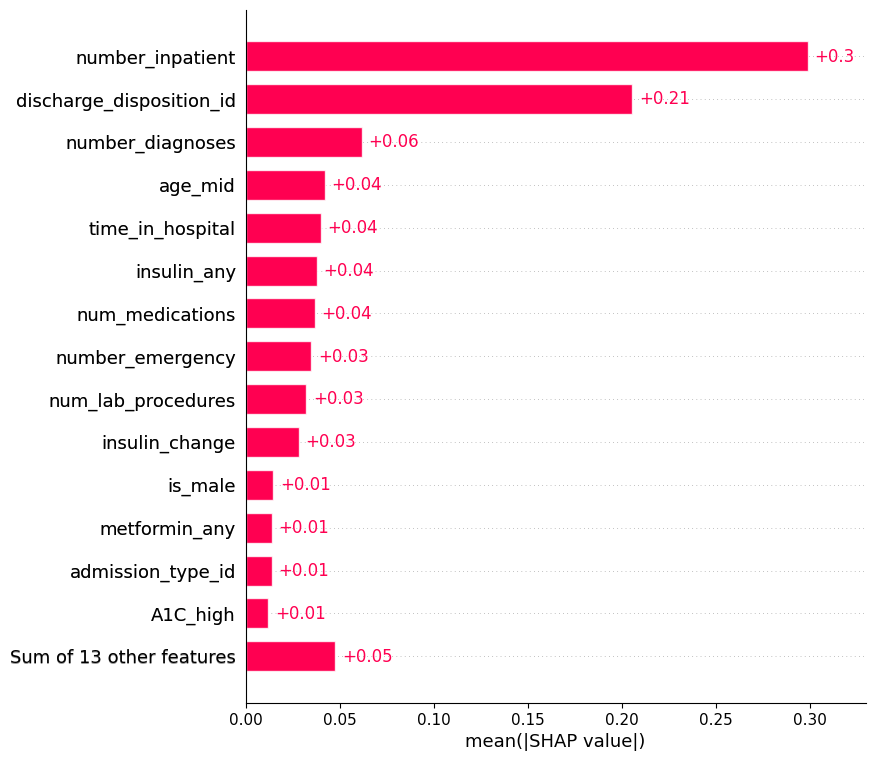

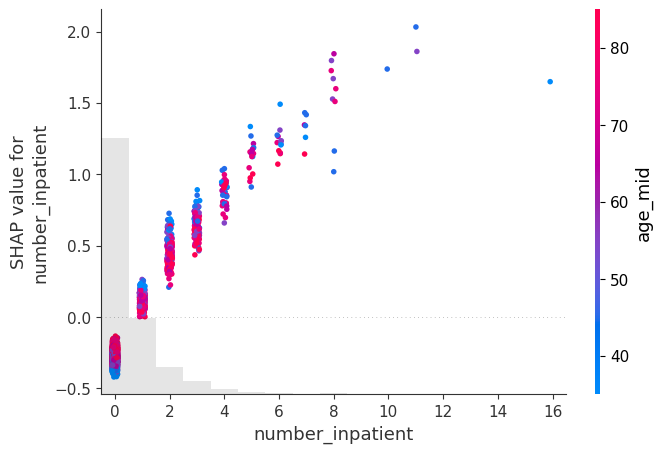

In [47]:
# SHAP — global explanations

# computes SHAP values on a test subset (for speed),
# shows beeswarm (global importance + direction),
# shows bar (global magnitude),
# shows dependence plot for the top driver.

# Take a sample for faster SHAP computation
sample_idx = np.random.choice(X_test.index, size=min(3000, len(X_test)), replace=False)
X_sample = X_test.loc[sample_idx]

# Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_sample)

# Global importance (directional)
shap.plots.beeswarm(shap_values, max_display=15)

# Global magnitude
shap.plots.bar(shap_values, max_display=15)

# Dependence plot for the top feature
top_feature = X_sample.columns[np.argmax(np.abs(shap_values.values).mean(0))]
shap.plots.scatter(shap_values[:, top_feature], color=shap_values)


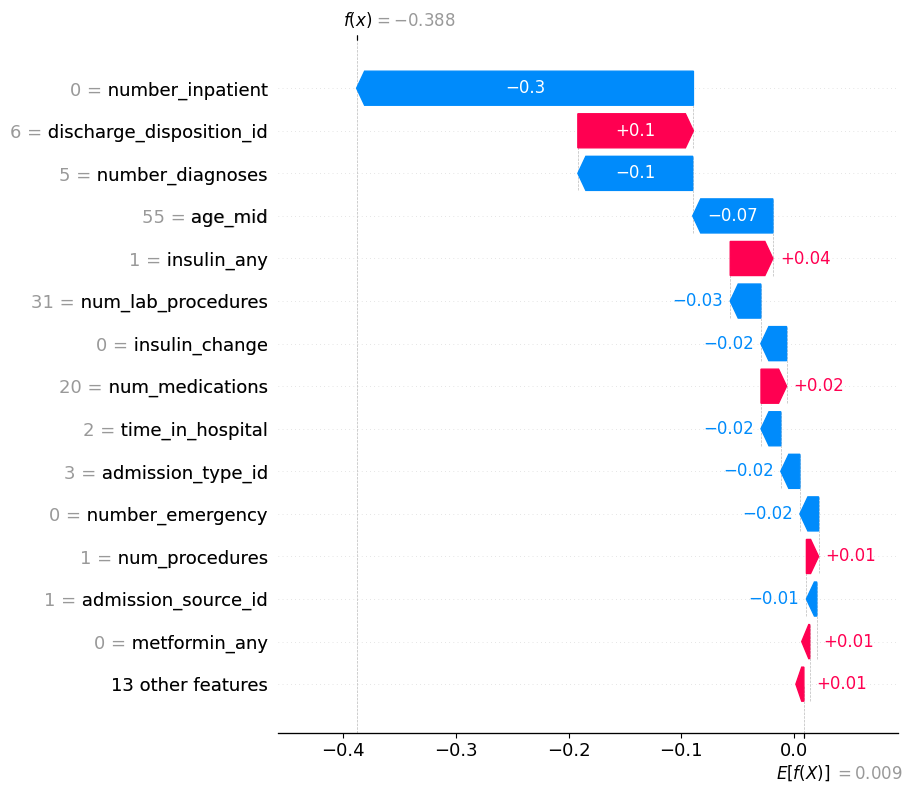

In [48]:
# SHAP — local explanation (single patient)

# picks one test patient by index,
# renders a waterfall plot: baseline → per‑feature pushes → final risk.

# Pick one patient from the test set (change index as you like)
x_one = X_test.iloc[[10]]

# SHAP for that patient
sv_one = explainer(x_one)

# Waterfall (per-feature contributions)
shap.plots.waterfall(sv_one[0], max_display=15)


===== Patient-level summary =====
Predicted 30-day readmission risk: 0.404
Model baseline (SHAP base value, log-odds): 0.009

Top factors increasing risk:
  + discharge_disposition_id = 6.0  (SHAP +0.103)
  + insulin_any = 1.0  (SHAP +0.038)
  + num_medications = 20.0  (SHAP +0.023)
  + num_procedures = 1.0  (SHAP +0.011)
  + metformin_any = 0.0  (SHAP +0.006)
  + A1C_high = 0.0  (SHAP +0.003)
  + is_male = 1.0  (SHAP +0.003)
  + glimepiride_any = 0.0  (SHAP +0.003)

Top factors reducing risk:
  - number_inpatient = 0.0  (SHAP -0.299)
  - number_diagnoses = 5.0  (SHAP -0.102)
  - age_mid = 55.0  (SHAP -0.071)
  - num_lab_procedures = 31.0  (SHAP -0.027)
  - insulin_change = 0.0  (SHAP -0.023)
  - time_in_hospital = 2.0  (SHAP -0.018)
  - admission_type_id = 3.0  (SHAP -0.017)
  - number_emergency = 0.0  (SHAP -0.017)


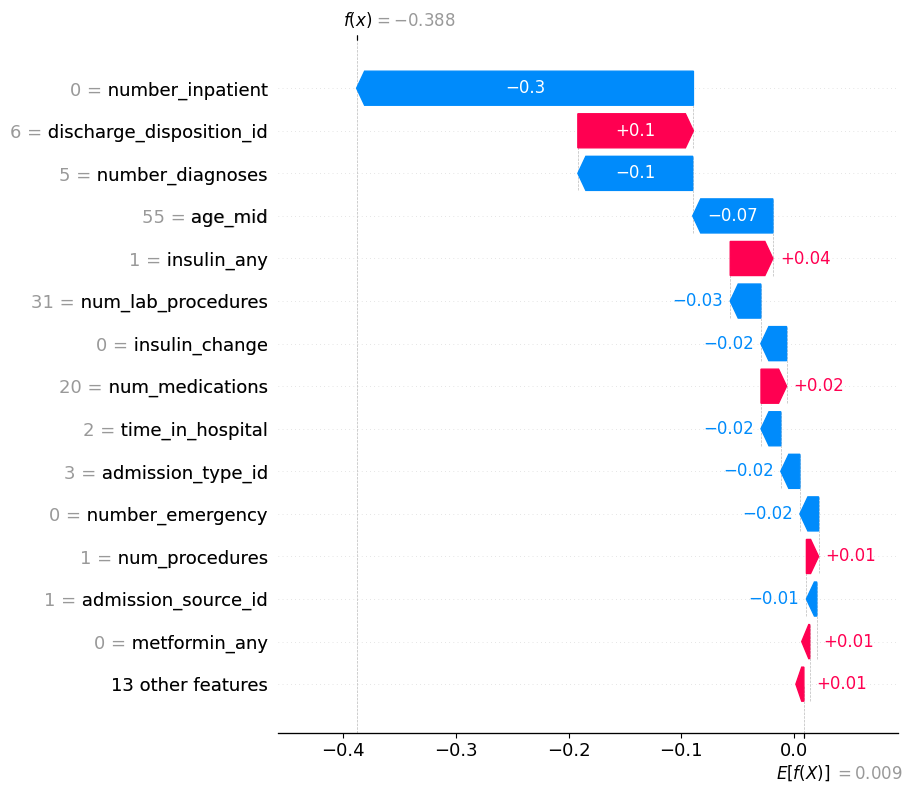

In [49]:
# Patient‑level summary function (“what & why”)

# returns a concise, text‑first explanation for a selected patient,
# lists top risk‑increasing and risk‑reducing features with their values,
# shows the waterfall plot for visual support.

def explain_single_patient(x_row: pd.DataFrame, top_k: int = 8):
    """
    Create a concise textual + visual explanation for a single patient row.
    Assumes global 'model' and 'explainer' exist.
    """
    assert x_row.shape[0] == 1, "Pass a single-row DataFrame."
    # Predicted probability
    p = float(model.predict_proba(x_row)[:,1])
    # SHAP values (new API)
    sv = explainer(x_row)
    vals = sv.values[0]         # per-feature SHAP contributions
    base = float(sv.base_values[0]) if hasattr(sv, "base_values") else None
    
    # Build a tidy table
    contrib = pd.DataFrame({
        "feature": x_row.columns,
        "value": x_row.iloc[0].values,
        "shap": vals
    }).sort_values("shap", key=np.abs, ascending=False)
    
    # Top pushes up / down
    up = contrib.sort_values("shap", ascending=False).head(top_k)
    down = contrib.sort_values("shap", ascending=True).head(top_k)
    
    print("===== Patient-level summary =====")
    print(f"Predicted 30-day readmission risk: {p:.3f}")
    if base is not None:
        print(f"Model baseline (SHAP base value, log-odds): {base:.3f}")
    print("\nTop factors increasing risk:")
    for _, r in up.iterrows():
        print(f"  + {r['feature']} = {r['value']}  (SHAP +{r['shap']:.3f})")
    print("\nTop factors reducing risk:")
    for _, r in down.iterrows():
        print(f"  - {r['feature']} = {r['value']}  (SHAP {r['shap']:.3f})")
    
    # Visual support
    shap.plots.waterfall(sv[0], max_display=15)

# Example usage:
explain_single_patient(X_test.iloc[[10]])


In [50]:
# Cohort‑level summary (“for whom and why”)

# lets you define a cohort with a boolean mask (e.g., age ≥ 70 & A1C_high == 1),
# reports cohort size, average predicted risk, and deltas vs. the whole test set,
# computes mean SHAP per feature over the cohort to show direction (positive = raises risk; negative = reduces),
# also computes mean |SHAP| to show magnitude,
# prints top drivers and plots a horizontal bar chart.

def summarize_cohort(X_frame: pd.DataFrame, mask: pd.Series, top_k: int = 12):
    """
    Summarize risk and SHAP drivers for a cohort defined by `mask`.
    Assumes global 'model', 'explainer', 'X_test', 'y_test'.
    """
    assert len(mask) == len(X_frame)
    cohort_X = X_frame[mask]
    if len(cohort_X) == 0:
        print("Cohort is empty. Adjust your mask.")
        return
    
    # Predicted probabilities
    p_all = model.predict_proba(X_frame)[:,1]
    p_coh = model.predict_proba(cohort_X)[:,1]
    print("===== Cohort summary =====")
    print(f"Cohort size: {len(cohort_X)} / {len(X_frame)} ({len(cohort_X)/len(X_frame):.1%})")
    print(f"Avg predicted risk (cohort): {p_coh.mean():.3f}")
    print(f"Avg predicted risk (overall): {p_all.mean():.3f}")
    print(f"Difference (cohort - overall): {p_coh.mean() - p_all.mean():+.3f}")
    
    # SHAP on the cohort (may take seconds if large; sample if needed)
    sv = explainer(cohort_X)
    vals = sv.values      # shape: [n_cohort, n_features]
    
    # Direction: mean SHAP (signed), Magnitude: mean absolute SHAP
    dir_series = pd.Series(vals.mean(axis=0), index=cohort_X.columns, name="mean_shap")
    mag_series = pd.Series(np.abs(vals).mean(axis=0), index=cohort_X.columns, name="mean_abs_shap")
    summary = pd.concat([dir_series, mag_series], axis=1)
    
    # Top features by magnitude
    top = summary.sort_values("mean_abs_shap", ascending=False).head(top_k)
    print("\nTop drivers (by magnitude):")
    for f, r in top.iterrows():
        arrow = "↑" if r["mean_shap"] > 0 else "↓"
        print(f"  {f:25s}  {arrow}  mean|SHAP|={r['mean_abs_shap']:.4f}  (mean SHAP={r['mean_shap']:+.4f})")
    
    # Simple bar plot (magnitude) with color by direction
    plt.figure(figsize=(8, max(3, 0.4*len(top))))
    colors = ["tab:red" if v>0 else "tab:blue" for v in top["mean_shap"]]
    plt.barh(top.index[::-1], top["mean_abs_shap"][::-1], color=colors[::-1])
    plt.xlabel("Mean |SHAP| (importance)")
    plt.title("Cohort drivers by SHAP magnitude (color=direction)")
    plt.tight_layout(); plt.show()

===== Cohort summary =====
Cohort size: 615 / 15017 (4.1%)
Avg predicted risk (cohort): 0.474
Avg predicted risk (overall): 0.462
Difference (cohort - overall): +0.012

Top drivers (by magnitude):
  number_inpatient           ↓  mean|SHAP|=0.2459  (mean SHAP=-0.1139)
  discharge_disposition_id   ↑  mean|SHAP|=0.1976  (mean SHAP=+0.0157)
  A1C_high                   ↓  mean|SHAP|=0.0509  (mean SHAP=-0.0507)
  number_diagnoses           ↑  mean|SHAP|=0.0499  (mean SHAP=+0.0099)
  num_medications            ↓  mean|SHAP|=0.0427  (mean SHAP=-0.0016)
  age_mid                    ↑  mean|SHAP|=0.0400  (mean SHAP=+0.0311)
  time_in_hospital           ↑  mean|SHAP|=0.0354  (mean SHAP=+0.0040)
  insulin_any                ↑  mean|SHAP|=0.0330  (mean SHAP=+0.0029)
  number_emergency           ↓  mean|SHAP|=0.0289  (mean SHAP=-0.0086)
  num_lab_procedures         ↑  mean|SHAP|=0.0273  (mean SHAP=+0.0035)
  insulin_change             ↑  mean|SHAP|=0.0233  (mean SHAP=+0.0045)
  admission_type_id   

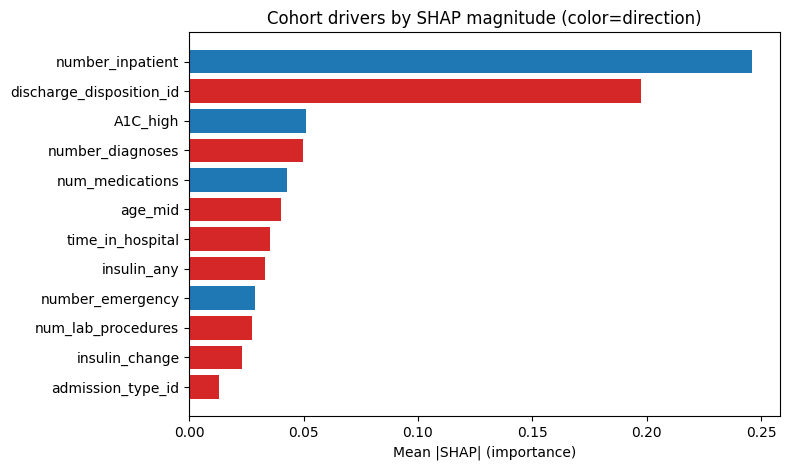

In [51]:
# 1) Older patients with high A1C
mask1 = (X_test["age_mid"] >= 70) & (X_test.get("A1C_high", 0) == 1)
summarize_cohort(X_test, mask1)


===== Cohort summary =====
Cohort size: 2101 / 15017 (14.0%)
Avg predicted risk (cohort): 0.660
Avg predicted risk (overall): 0.462
Difference (cohort - overall): +0.198

Top drivers (by magnitude):
  number_inpatient           ↑  mean|SHAP|=0.6742  (mean SHAP=+0.6742)
  discharge_disposition_id   ↓  mean|SHAP|=0.1331  (mean SHAP=-0.0162)
  number_emergency           ↑  mean|SHAP|=0.0471  (mean SHAP=+0.0186)
  number_diagnoses           ↑  mean|SHAP|=0.0332  (mean SHAP=+0.0072)
  num_medications            ↑  mean|SHAP|=0.0317  (mean SHAP=+0.0003)
  time_in_hospital           ↑  mean|SHAP|=0.0291  (mean SHAP=+0.0007)
  insulin_any                ↑  mean|SHAP|=0.0265  (mean SHAP=+0.0016)
  insulin_change             ↑  mean|SHAP|=0.0252  (mean SHAP=+0.0038)
  age_mid                    ↓  mean|SHAP|=0.0239  (mean SHAP=-0.0005)
  num_lab_procedures         ↓  mean|SHAP|=0.0238  (mean SHAP=-0.0028)
  metformin_any              ↑  mean|SHAP|=0.0221  (mean SHAP=+0.0002)
  number_outpatient 

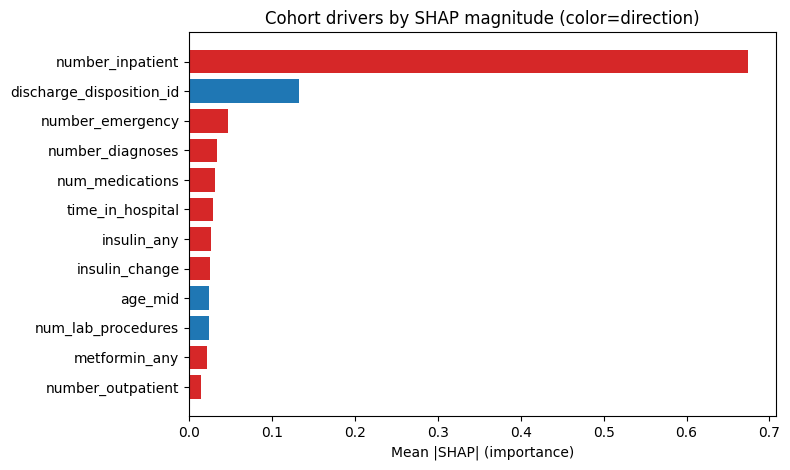

In [52]:
# 2) Recently hospitalized multiple times (proxy severity)
mask2 = (X_test["number_inpatient"] >= 2)
summarize_cohort(X_test, mask2)


# ✅ Summary & Key Takeaways

In this notebook we explored the challenge of **predicting 30-day hospital readmission in diabetic patients** using  
the open *Diabetes 130-US hospitals* dataset (1999–2008).

### What we did
- Cleaned and engineered clinically interpretable features (age, labs, utilization, medications).  
- Trained a gradient boosting model (**XGBoost**) with early stopping.  
- Evaluated performance using **ROC-AUC** and **PR-AUC** (better for imbalanced outcomes).  
- Applied **SHAP** to interpret model behavior:  
  - **Global level:** which features matter most overall (e.g., prior inpatient visits, A1C, number of medications).  
  - **Local level:** why the model made a prediction for an individual patient (waterfall plots).  
  - **Cohort level:** how risk factors differ in specific subgroups (e.g., older patients, those with high A1C).

### Key insights
- Prior hospital utilization (especially number of inpatient visits) and elevated A1C/glucose are among the strongest predictors of early readmission.  
- SHAP visualizations make the model’s reasoning **transparent and clinically intuitive**.  
- Cohort summaries reveal how risk is distributed across patient subgroups.  

### Limitations
- Dataset is dated (1999–2008) and U.S.-specific.  
- Features are limited (e.g., no socioeconomic variables, no outpatient follow-up data).  
- Model is **for demonstration only** — not validated for clinical use.

### Next steps
- Experiment with additional models (e.g., LightGBM, logistic regression baseline).  
- Explore calibration and decision thresholds (precision vs. recall trade-offs).  
- Extend analysis with richer EHR data or more recent cohorts.  
- Package the model into a small web app (Streamlit/Gradio) for interactive demos.

---

⚠️ **Disclaimer:** This project is intended for educational purposes (Coursera *AI for Medicine* specialization) and **must not be used for real clinical decision-making**.
